In [4]:
import pandas as pd
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt

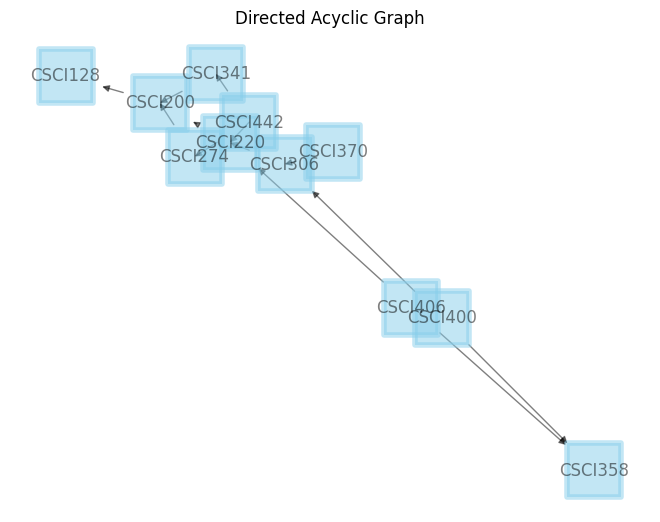

In [6]:
# create dag using networkx from ../data/dag_simple.csv
reader = pd.read_csv('../data/dag_simple.csv')
dag = nx.DiGraph()

for i in range(len(reader)):
    dag.add_edge(reader['prereq'][i], reader['class'][i])

# plot the dag
pos = nx.spring_layout(dag)
nx.draw(dag, pos, with_labels=True, node_size=1500, node_color="skyblue", node_shape="s", alpha=0.5, linewidths=4)
plt.title('Directed Acyclic Graph')
plt.show()